In [1]:
import tbitk.data_manager as dm

In [ ]:
data_dir = '../data/unskilled_operator-20220421/manual_onsd-Brad Moore-1/'
glob_pat = f'{data_dir}/**/*cornerText.json'
files = dm.posix_glob(glob_pat, recursive=True)

In [2]:
import re
import json
import pdb
import pandas as pd
import numpy as np
import itk

def get_other_files(f):
    '''
    
    Parameters
    ----------
    f : str
        Path to cornerText.json, has to be under "manual_onsd-Brad Moore-1"
    
    Returns
    -------
    rulers_path
    preprocessed_path
    device
    user
    head
    video
    '''
    f2 = f.replace('cornerText.json', 'rulers.json')
    f3 = f.replace('manual_onsd-Brad Moore-1', 'preprocessed').replace('cornerText.json', 'mha')
    
    exp_pat = r'.*/(?P<device>[^/]+)/(?P<user>[\d]+)/\d+\-(?P<head>\d+)\-(?P<video>\d+).mha$'
    m = re.match(exp_pat, f3)
    return f2, f3, m.group('device'), m.group('user'), m.group('head'), m.group('video')

def get_image_meta(preprocessed_f):
    # gotta factor in the issue with black frames at the end (sonoque)
    img = itk.imread(preprocessed_f)
    blank_idxs = np.argwhere(np.sum(np.sum(img, axis=2), axis=1) == 0)
    idx_len = img.shape[0] if len(blank_idxs) == 0 else int(blank_idxs[0])
    spacing = img.GetSpacing()[0]
    framerate = img.GetSpacing()[2]
    duration = framerate * idx_len
    return spacing, framerate, idx_len, duration

def get_row(f):
    # parse cornerText.json
    onsd_f, preprocessed_f, device, user, head, video = get_other_files(f)
    spacing, framerate, idx_len, duration = get_image_meta(preprocessed_f)
    
    pass_success = None
    pass_total = None
    comment = None
    txt = None
    with open(f, 'r') as fp:
        corner_txt = json.load(fp)
        try:
            txt = corner_txt['cornerTexts'][0]['text']
            m = re.match(f'(passes=(((?P<pass_success>\d+)/(?P<pass_total>\d+))|NA))?(;(?P<comment>.*))?', txt)
            d = m.groupdict()
            pass_success = int(d['pass_success'])
            pass_total = int(d['pass_total'])
            comment = d['comment']
        except:
            pass

    onsd = None
    with open(onsd_f, 'r') as fp:
        tmp = json.load(fp)
        try:
            onsd_r = [ r for r in tmp['rulers'][0]['rulers'] if r['name'] == 'ONSD' ][0]
            onsd = onsd_r['distance']
            
        except:
            pass
        
    return device, user, head, video, onsd, pass_success, pass_total, spacing, framerate, idx_len, duration, comment, txt

def get_dataframe(files):
    print(len(files))
    data = []
    for f in files:
        print(f)
        data.append(list(get_row(f)))
    
    return pd.DataFrame(data, columns=['device', 'user', 'head', 'video', 'onsd', 'pass_success', 'pass_total', 'spacing', 'framerate', 'idx_len', 'duration', 'comment', 'txt'])

In [ ]:
df = get_dataframe(files)
df

In [ ]:
df.to_csv('per_video_annotation.csv')

In [ ]:
# need to aggregate by stuff
df_aggr = df.groupby(by=['device', 'user', 'head'], as_index=False).agg({ 'onsd' : np.random.choice, 'pass_success' : 'sum', 'pass_total' : 'sum' , 'duration' : 'sum' })
df_aggr.replace([None], 0, inplace=True)
df_aggr['passes_per_second'] = df_aggr['pass_total'] / df_aggr['duration']


In [19]:
df_aggr.to_csv('aggr_video_annotation.csv')

In [3]:
df = pd.read_csv('per_video_annotation.csv')
df_aggr = pd.read_csv('aggr_video_annotation.csv')

In [4]:
df_aggr

,Unnamed: 0,device,user,head,onsd,pass_success,pass_total,duration,passes_per_second
0,0,butterfly-iq,1,1,3.4641,7.0,7.0,44.143854,0.158572
1,1,butterfly-iq,1,2,4.5619,7.0,7.0,51.385833,0.136224
2,2,butterfly-iq,1,3,5.9834,9.0,9.0,51.032292,0.176359
3,3,butterfly-iq,2,1,2.9242,4.0,4.0,48.872188,0.081846
4,4,butterfly-iq,2,2,5.8939,6.0,6.0,48.853854,0.122815
...,...,...,...,...,...,...,...,...,...
130,130,sonoque-l5c,8,2,5.3592,3.0,3.0,33.333333,0.090000
131,131,sonoque-l5c,8,3,5.7263,2.0,2.0,33.333333,0.060000
132,132,sonoque-l5c,9,1,3.6672,2.0,4.0,33.333333,0.120000
133,133,sonoque-l5c,9,2,5.1768,5.0,5.0,33.333333,0.150000


In [5]:
df_aggr[df_aggr.passes_per_second < 0.02]
df_aggr = df_aggr[df_aggr.passes_per_second >= 0.02] # censor out 


,Unnamed: 0,device,user,head,onsd,pass_success,pass_total,duration,passes_per_second
28,28,clarius-l7hd,1,2,NaN,0.0,0.0,9.291667,0.0
29,29,clarius-l7hd,1,3,NaN,0.0,0.0,9.291667,0.0
95,95,sonivate,5,3,NaN,0.0,0.0,33.666667,0.0


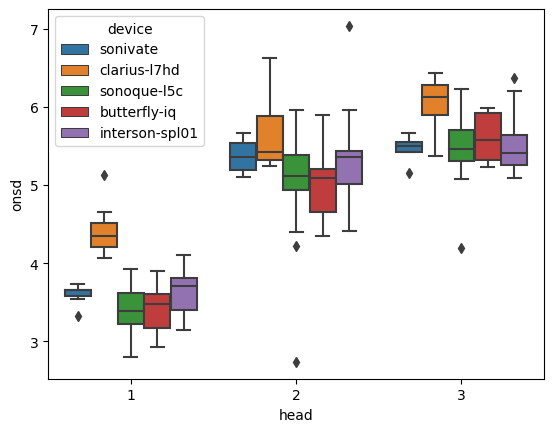

In [7]:
import plotly as pl
import plotly.express as px
import seaborn as sb
g = sb.boxplot(data=df, hue='device', x='head', y='onsd')
# fig = px.scatter(df_aggr, x='user', y='passes_per_second')
# fig.show()

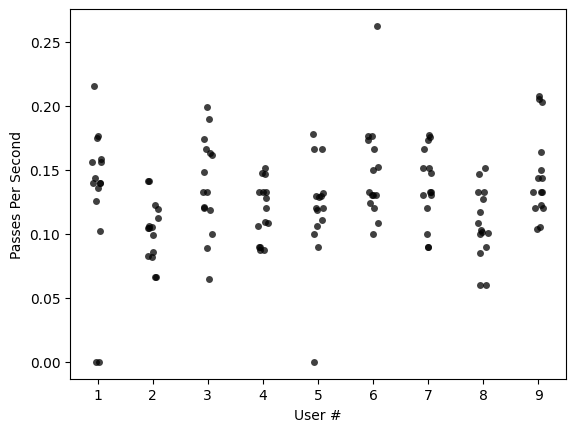

In [9]:
import matplotlib.pyplot as plt
sb.stripplot(
    data=df_aggr, x="user", y="passes_per_second",
    dodge=True, alpha=.75, zorder=1, color='black'
).set(xlabel='User #', ylabel='Passes Per Second')
plt.savefig('../data/phantom_study-202201/analysis/fig-unskilled-passes.pdf', bbox_inches='tight')

You should consider upgrading via the 'C:\src\MTECTraumaticBrainInjury\UltrasoundQuality\python\venv-analysis\Scripts\python.exe -m pip install --upgrade pip' command.


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf



model = smf.ols('passes_per_second ~ user - 1', data=df_aggr)

res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      passes_per_second   R-squared (uncentered):                   0.750
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              401.2
Date:                Sat, 21 Jan 2023   Prob (F-statistic):                    4.04e-42
Time:                        11:51:44   Log-Likelihood:                          173.65
No. Observations:                 135   AIC:                                     -345.3
Df Residuals:                     134   BIC:                                     -342.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
user           0.0206      0.001     20.029      0.000       0.019       0.023
==============================================================================
Omnibus:                        1.430   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.489   Jarque-Bera (JB):                1.420
Skew:                           0.160   Prob(JB):                        0.492
Kurtosis:                       2.612   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

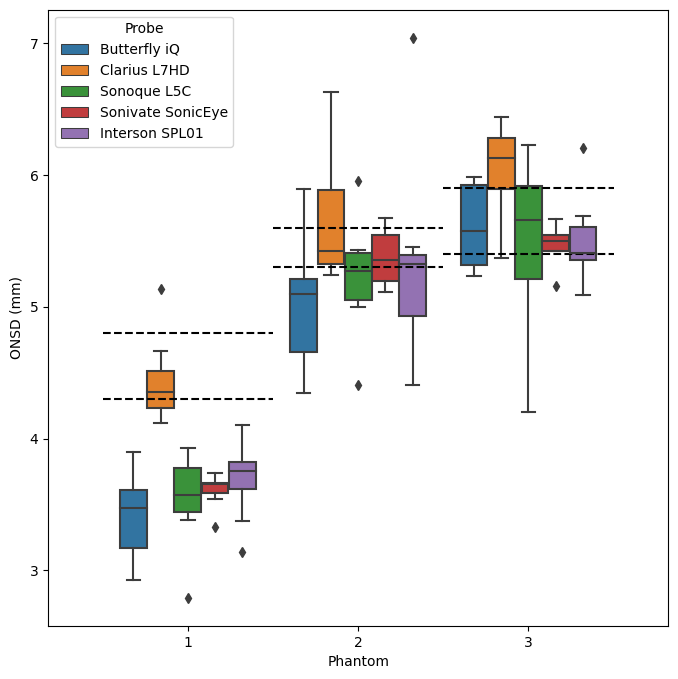

In [11]:
import seaborn as sb
import matplotlib.pyplot as plt
from usqc.manuscript import PROBE_PRETTY, PROBE_ORDERED


df_aggr.replace(PROBE_PRETTY, inplace=True)
df_aggr.rename({'device' : 'Probe'}, axis=1, inplace=True)
df_aggr.Probe = pd.Categorical(df_aggr.Probe, categories=PROBE_ORDERED, ordered=True)
fig, ax = plt.subplots(1,1, figsize=(8,8))
g = sb.boxplot(data=df_aggr, hue='Probe', x='head', y='onsd', ax=ax).set(xlabel='Phantom', ylabel='ONSD (mm)')
ax.plot([-0.5, .5], [4.3, 4.3], ls='--', c='black')
ax.plot([-0.5, .5], [4.8, 4.8], ls='--', c='black')
ax.plot([.5, 1.5], [5.3, 5.3], ls='--', c='black')
ax.plot([.5, 1.5], [5.6, 5.6], ls='--', c='black')
ax.plot([1.5, 2.5], [5.4, 5.4], ls='--', c='black')
ax.plot([1.5, 2.5], [5.9, 5.9], ls='--', c='black')
plt.savefig('../data/phantom_study-202201/analysis/fig-unskilled-manual-onsd-boxplot.pdf', bbox_inches='tight')
# ax2.axhline(30, ls='--')

In [12]:
df_aggr

,Unnamed: 0,Probe,user,head,onsd,pass_success,pass_total,duration,passes_per_second
0,0,Butterfly iQ,1,1,3.4641,7.0,7.0,44.143854,0.158572
1,1,Butterfly iQ,1,2,4.5619,7.0,7.0,51.385833,0.136224
2,2,Butterfly iQ,1,3,5.9834,9.0,9.0,51.032292,0.176359
3,3,Butterfly iQ,2,1,2.9242,4.0,4.0,48.872188,0.081846
4,4,Butterfly iQ,2,2,5.8939,6.0,6.0,48.853854,0.122815
...,...,...,...,...,...,...,...,...,...
130,130,Sonoque L5C,8,2,5.3592,3.0,3.0,33.333333,0.090000
131,131,Sonoque L5C,8,3,5.7263,2.0,2.0,33.333333,0.060000
132,132,Sonoque L5C,9,1,3.6672,2.0,4.0,33.333333,0.120000
133,133,Sonoque L5C,9,2,5.1768,5.0,5.0,33.333333,0.150000


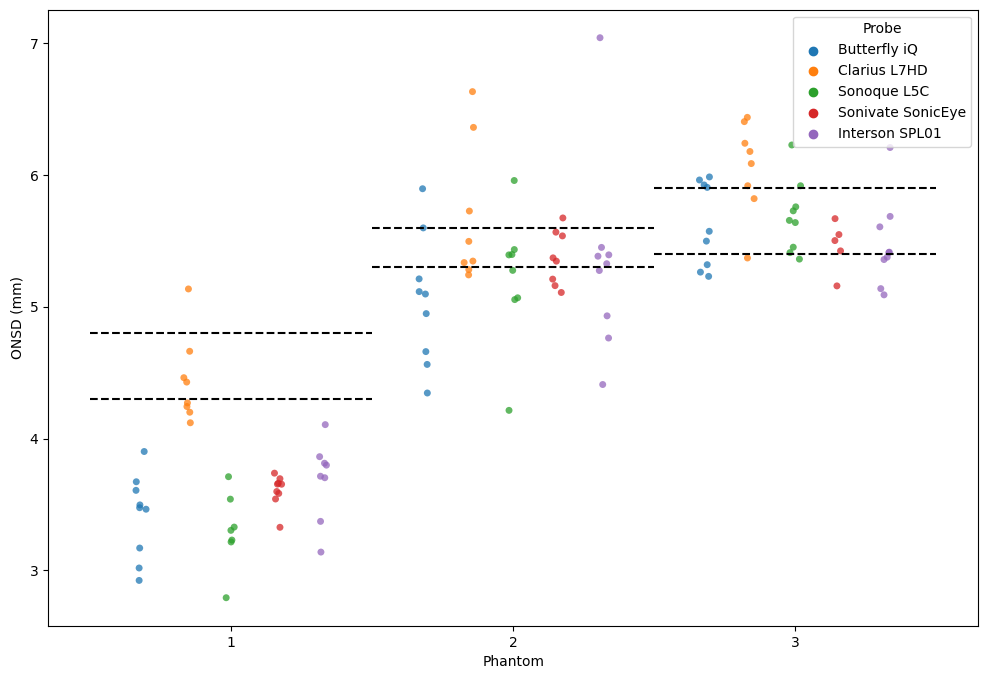

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sb.stripplot(
    data=df_aggr, x="head", y="onsd", hue="Probe",
    dodge=True, alpha=.75, zorder=1, ax=ax
).set(xlabel='Phantom', ylabel='ONSD (mm)')
ax.plot([-0.5, .5], [4.3, 4.3], ls='--', c='black')
ax.plot([-0.5, .5], [4.8, 4.8], ls='--', c='black')
ax.plot([.5, 1.5], [5.3, 5.3], ls='--', c='black')
ax.plot([.5, 1.5], [5.6, 5.6], ls='--', c='black')
ax.plot([1.5, 2.5], [5.4, 5.4], ls='--', c='black')
ax.plot([1.5, 2.5], [5.9, 5.9], ls='--', c='black')
plt.savefig('../data/phantom_study-202201/analysis/fig-unskilled-manual-onsd-scatter.pdf', bbox_inches='tight')

In [56]:
import plotly as pl
import plotly.express as px
# g = sb.boxplot(data=df, hue='device', x='head', y='onsd', ax=ax)
fig = px.scatter(df_aggr, x='head', y='onsd', color='device')
fig.show()
plt.savefig('../data/phantom_study-202201/analysis/fig-unskilled-manual-onsd-scatter.pdf', bbox_inches='tight')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [46]:
df_aggr = df.groupby(['device', 'head'], as_index=False).agg({ 'onsd' : ['mean', 'std'] })
df_aggr

device head      onsd          
                             mean       std
0     butterfly-iq    1  3.414378  0.318377
1     butterfly-iq    2  5.047122  0.492642
2     butterfly-iq    3  5.627500  0.318043
3     clarius-l7hd    1  4.412680  0.315755
4     clarius-l7hd    2  5.676250  0.532399
5     clarius-l7hd    3  6.055238  0.350600
6   interson-spl01    1  3.631680  0.292576
7   interson-spl01    2  5.393090  0.718008
8   interson-spl01    3  5.527727  0.421079
9         sonivate    1  3.605856  0.120159
10        sonivate    2  5.370413  0.206056
11        sonivate    3  5.458920  0.190495
12     sonoque-l5c    1  3.426413  0.303540
13     sonoque-l5c    2  4.978481  0.727905
14     sonoque-l5c    3  5.479956  0.436125

In [15]:
df_aggr.columns


MultiIndex([('device',     ''),
            (  'head',     ''),
            (  'onsd', 'mean'),
            (  'onsd',  'std')],
           )

<AxesSubplot:xlabel='head', ylabel="('onsd', 'std')">

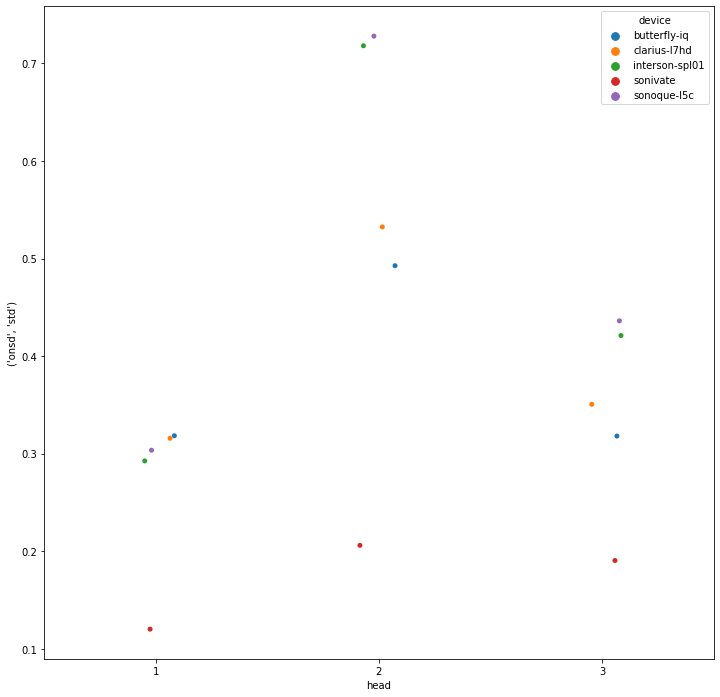

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
sb.stripplot(data=df_aggr, x="head", y=('onsd','std'), hue='device', ax=ax)

In [17]:
df2 = df[df.pass_total.notna()]
df2['pass_ratio'] = df2['pass_success'] / df2['pass_total']

# m = re.match(f'(passes=(M|NA))?(;(?P<comment>.*))?', test_txt)

C:\Users\brad.moore\AppData\Local\Temp\ipykernel_30744\2996236118.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
df2.groupby(['device'], as_index=False).agg({ 'pass_ratio' : ['mean', 'std'] })

device pass_ratio          
                        mean       std
0    butterfly-iq   0.921869  0.186915
1    clarius-l7hd   0.917308  0.163672
2  interson-spl01   0.832378  0.309757
3        sonivate   0.516728  0.350693
4     sonoque-l5c   0.923077  0.250188

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp = df
#tmp.head = pd.Categorical(tmp.head, categories=[1,2,3], ordered=True)
mean_head = {1 : (4.3+4.8)/2.0, 2 : (5.3+5.6)/2, 3 : (5.4+5.9)/2}
tmp['mean_head'] = [ mean_head[x] for x in tmp['head'] ]
tmp['diff'] = tmp.onsd-tmp.mean_head
model = smf.ols('diff ~ device + 0', data=tmp)
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     6.930
Date:                Mon, 23 Jan 2023   Prob (F-statistic):           3.80e-05
Time:                        14:52:15   Log-Likelihood:                -133.15
No. Observations:                 155   AIC:                             276.3
Df Residuals:                     150   BIC:                             291.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
device[butterfly-iq]      -0.5203      0.112     -4.656      0.000      -0.741      -0.300
device[clarius-l7hd]       0.1415      0.114      1.242      0.216      -0.084       0.367
device[interson-spl01]    -0.3580      0.104     -3.432      0.001      -0.564      -0.152
device[sonivate]          -0.4586      0.124     -3.704      0.000      -0.703      -0.214
device[sonoque-l5c]       -0.5604      0.083     -6.755      0.000      -0.724      -0.396
==============================================================================
Omnibus:                        3.484   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                3.885
Skew:                          -0.085   Prob(JB):                        0.143
Kurtosis:                       3.757   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
from patsy.contrasts import Sum, Simple

ImportError: cannot import name 'Simple' from 'patsy.contrasts' (C:\src\MTECTraumaticBrainInjury\UltrasoundQuality\python\venv-analysis\lib\site-packages\patsy\contrasts.py)

In [20]:
Sum().code_without_intercept(['butterfly-iq', 'clarius-l7hd', 'interson-spl01', 'sonivate', 'sonoque-l5c'])

ContrastMatrix(array([[ 1.,  0.,  0.,  0.],
                      [ 0.,  1.,  0.,  0.],
                      [ 0.,  0.,  1.,  0.],
                      [ 0.,  0.,  0.,  1.],
                      [-1., -1., -1., -1.]]),
               ['[S.butterfly-iq]',
                '[S.clarius-l7hd]',
                '[S.interson-spl01]',
                '[S.sonivate]'])

In [ ]:
mod = smf.ols('onsd ~ C(device, Simple) + head + 0', data=tmp)
res=mod.fit()
print(res.summary())